In [17]:
from data_gen import generate_random_shapes_image, blur_image
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import cv2
from pathlib import Path
from tqdm import tqdm
import torch.amp
import seaborn as sns

from matplotlib import pyplot as plt
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])
sigma_range=(0, 10)
sigma_mean = (sigma_range[1] - sigma_range[0]) / 2
sigma_std = (sigma_range[1] - sigma_range[0]) / 2
# Custom Dataset
class BlurDataset(Dataset):
    def __init__(self,  length=10000):
        self.length = length

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        image = generate_random_shapes_image()

        # Convert to numpy for OpenCV blur
        image_np = np.asarray(image)

        # Generate random sigma and apply Gaussian blur
        sigma = np.random.uniform(sigma_range[0], sigma_range[1])
        blurred = blur_image(image_np, sigma)
        blurred_pil = Image.fromarray(blurred)  # Convert back to PIL for transforms

        blurred_tensor = transform(blurred_pil)

        if blurred_tensor.shape != (1, 128, 128):
            raise ValueError(f"Unexpected tensor shape: {blurred_tensor.shape}")

        # Normalize sigma to be between 0 and 1

        sigma_normalized = (sigma - sigma_mean) / sigma_std
        return blurred_tensor, torch.tensor(sigma_normalized, dtype=torch.float32)


# CNN Model
class BlurRegressionCNN(nn.Module):
    def __init__(self):
        super(BlurRegressionCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
        )
        self.regressor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 512),  # Corrected for 128x128 input
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 1),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.regressor(x)
        return x.squeeze(-1)


# Training function
def train_model(model, train_loader, val_loader, num_epochs=10, lr=1e-3):
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    scaler = torch.amp.GradScaler("cuda")

    best_val_loss = float("inf")
    model_path = "best_blur_model.pth"

    losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for images, sigmas in tqdm(
            train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"
        ):
            images, sigmas = images.to(device), sigmas.to(device)

            optimizer.zero_grad()
            with torch.amp.autocast("cuda"):
                outputs = model(images)
                loss = criterion(outputs, sigmas)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item() * images.size(0)

        train_loss /= len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, sigmas in val_loader:
                images, sigmas = images.to(device), sigmas.to(device)
                outputs = model(images)
                loss = criterion(outputs, sigmas)
                val_loss += loss.item() * images.size(0)

        val_loss /= len(val_loader.dataset)
        losses.append((train_loss, val_loss))
        print(
            f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}"
        )

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), model_path)
            print(f"Saved best model with Val Loss: {val_loss:.4f}")

        scheduler.step()
    plt.plot([l[0] for l in losses], label="Training Loss")
    plt.plot([l[1] for l in losses], label="Validation Loss")
    plt.legend()
    plt.yscale("log")
    plt.show()

    return model


def main():
    # Hyperparameters
    batch_size = 128
    num_epochs = 2
    learning_rate = 1e-3
    val_split = 0.2

    # Dataset
    dataset = BlurDataset(length=12800)

    # Split into train and validation
    train_size = int((1 - val_split) * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size]
    )

    # DataLoaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=8,
        pin_memory=True,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=8,
        pin_memory=True,
    )
    global model
    # Model
    model = BlurRegressionCNN().to(device)

    # Train
    model = train_model(model, train_loader, val_loader, num_epochs, learning_rate)

    print("Training completed!")



cuda


Epoch 1/2: 100%|██████████| 80/80 [00:17<00:00,  4.58it/s]


Epoch 1/2, Train Loss: 245.3620, Val Loss: 0.3152
Saved best model with Val Loss: 0.3152


Epoch 2/2: 100%|██████████| 80/80 [00:16<00:00,  4.82it/s]


Epoch 2/2, Train Loss: 0.3601, Val Loss: 0.2701
Saved best model with Val Loss: 0.2701


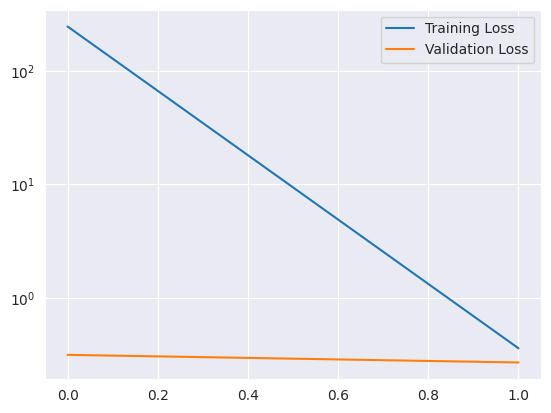

Training completed!


In [18]:
main()

In [12]:
def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    predictions = []
    ground_truths = []

    with torch.no_grad():
        for images, sigmas in tqdm(test_loader, desc="Evaluating"):
            images, sigmas = images.to(device), sigmas.to(device)
            outputs = model(images)
            loss = criterion(outputs, sigmas)
            test_loss += loss.item() * images.size(0)

            # The normalization in BlurDataset is: sigma_normalized = (sigma - sigma_min) / (sigma_max - sigma_min)
            # So, to denormalize: sigma = sigma_normalized * (sigma_max - sigma_min) + sigma_min
            outputs_denorm = outputs.cpu().numpy() * sigma_std + sigma_mean
            sigmas_denorm = sigmas.cpu().numpy() * sigma_std + sigma_mean

            predictions.extend(outputs_denorm)
            ground_truths.extend(sigmas_denorm)

    test_loss /= len(test_loader.dataset)
    predictions = np.array(predictions)
    ground_truths = np.array(ground_truths)

    return test_loss, predictions, ground_truths


def plot_results(test_loss, predictions, ground_truths, save_dir="plots"):
    # Créer le répertoire pour sauvegarder les plots
    Path(save_dir).mkdir(exist_ok=True)

    # 1. Scatter plot : Prédictions vs Valeurs réelles
    plt.figure(figsize=(10, 6))
    plt.scatter(ground_truths, predictions, alpha=0.5, s=10)
    plt.plot([0, 10], [0, 10], 'r--', label='Ligne idéale')
    plt.xlabel('Sigma réel')
    plt.ylabel('Sigma prédit')
    plt.title(f'Prédictions vs Valeurs réelles (Test Loss: {test_loss:.4f})')
    plt.legend()
    plt.grid(True)
    plt.savefig(Path(save_dir) / 'predictions_vs_ground_truth.png')
    plt.close()


    # 2. Histogramme des erreurs
    errors = predictions - ground_truths
    plt.figure(figsize=(10, 6))
    sns.histplot(errors, bins=50, kde=True)
    plt.xlabel('Erreur (Prédit - Réel)')
    plt.ylabel('Fréquence')
    plt.title('Distribution des erreurs de prédiction')
    plt.grid(True)
    plt.savefig(Path(save_dir) / 'error_distribution.png')
    plt.close()


    # 3. Erreur absolue en fonction de sigma réel
    abs_errors = np.abs(errors)
    plt.figure(figsize=(10, 6))
    plt.scatter(ground_truths, abs_errors, alpha=0.5, s=10)
    plt.xlabel('Sigma réel')
    plt.ylabel('Erreur absolue')
    plt.title('Erreur absolue en fonction de Sigma réel')
    plt.grid(True)
    plt.savefig(Path(save_dir) / 'absolute_error_vs_ground_truth.png')
    plt.close()

    # 4. Boxplot des erreurs par plage de sigma
    sigma_bins = np.linspace(0, 10, 11)
    digitized = np.digitize(ground_truths, sigma_bins)
    binned_errors = [abs_errors[digitized == i] for i in range(1, len(sigma_bins))]

    plt.figure(figsize=(10, 6))
    plt.boxplot(binned_errors, labels=[f'{sigma_bins[i]:.1f}-{sigma_bins[i+1]:.1f}'
                                     for i in range(len(sigma_bins)-1)])
    plt.xlabel('Plage de Sigma réel')
    plt.ylabel('Erreur absolue')
    plt.title('Distribution des erreurs par plage de Sigma')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(Path(save_dir) / 'error_by_sigma_range.png')
    plt.close()

In [13]:
    # Hyperparamètres
    batch_size = 128
    sigma_range = (0, 10)
    test_size = 2000

    # Charger le modèle entraîné
    # model = BlurRegressionCNN().to(device)
    global model
    # model_path = "best_blur_model.pth"
    # if not Path(model_path).exists():
    #     raise FileNotFoundError(f"Modèle non trouvé à {model_path}")
    # model.load_state_dict(torch.load(model_path))
    # print(f"Modèle chargé depuis {model_path}")

    # Créer le dataset de test
    test_dataset = BlurDataset(length=test_size)
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=8,
        pin_memory=True,
    )

    # Critère de perte
    criterion = nn.MSELoss()

    # Évaluer le modèle
    test_loss, predictions, ground_truths = evaluate_model(model, test_loader, criterion)

    # Afficher les résultats
    print(f"Test Loss: {test_loss:.4f}")
    print(f"MAE: {np.mean(np.abs(predictions - ground_truths)):.4f}")
    print(f"RMSE: {np.sqrt(np.mean((predictions - ground_truths)**2)):.4f}")

    # Visualiser les résultats
    plot_results(test_loss, predictions, ground_truths)

Evaluating: 100%|██████████| 16/16 [00:03<00:00,  5.25it/s]


Test Loss: 0.2436
MAE: 2.0838
RMSE: 2.4679


/tmp/ipykernel_10680/2777009023.py:75: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(binned_errors, labels=[f'{sigma_bins[i]:.1f}-{sigma_bins[i+1]:.1f}'
